In [1]:
import numpy as np
from itertools import islice, cycle
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, cm, colors
from IPython.display import HTML
from scipy._lib._util import check_random_state
%matplotlib inline

In [2]:
np.set_printoptions(precision=5, suppress=True)

old_settings = np.geterr()

new_settings = old_settings.copy()
new_settings["divide"] = "raise"
new_settings["invalid"] = "raise"
new_settings["over"] = "ignore"
new_settings["under"] = "ignore"

np.seterr(**new_settings)
# np.seterr(**old_settings)

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [3]:
from matplotlib import __version__
print __version__

1.5.0


In [4]:
from scipy.version import version
print version

0.16.1


In [5]:
import imm

In [6]:
def make_ellipse(mean, covariance, ax, color):
    
    v, w = np.linalg.eigh(covariance[:2, :2])
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # v *= 9 # blow up
    
    ell = mpl.patches.Ellipse(mean[:2], v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    
    return ell

In [7]:
def plot_data(x_n, c_n, phi_c=None, cmap=cm.get_cmap('gist_rainbow'),
              size=(10,10), seed=None):
    
    random_state = check_random_state(seed)
    
    unique, inverse = np.unique(c_n, return_inverse=True)
    rands = random_state.rand(len(unique))
    c = rands[inverse].reshape(c_n.shape)
    
    fig, ax = plt.subplots(figsize=size)
    
    scat = ax.scatter(x_n[:, 0], x_n[:, 1])
    
    scat.set_array(c)
    scat.set_cmap(cmap)
    # scat.set_norm(colors.Normalize(vmin=rands.min(), vmax=rands.max()))
    scat.set_norm(colors.Normalize(vmin=0, vmax=1))
    scat.set_linewidth(0)
    
    if phi_c is not None:
        for k, phi in phi_c.iteritems():
            mean = phi['mean']
            try:
                cov = phi['covariance']
            except:
                cov = np.linalg.inv(phi['precision'])
            ell = make_ellipse(mean, cov, ax,
                               cmap(rands[np.argmax(unique==k)]))
            ax.add_patch(ell)

In [8]:
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-webm;base64,{0}" type="video/webm">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.webm') as f:
            anim.save(f.name, fps=6, extra_args=['-vcodec', 'libvpx'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")

    return VIDEO_TAG.format(anim._encoded_video)

In [9]:
def anim_data(x_n, c_n, phi_c=None, cmap=cm.get_cmap('gist_rainbow'),
              size=(10,10), seed=None):
    
    random_state = check_random_state(seed)
    
    c_n = np.asarray(c_n, dtype=int)
    
    if c_n.ndim == 0:
        c_n = c_n[np.newaxis, np.newaxis]
    elif c_n.ndim == 1:
        c_n = c_n[np.newaxis, :]
    elif c_n.ndim > 2:
        raise ValueError
    
    numframes, n = c_n.shape
    
    unique, inverse = np.unique(c_n, return_inverse=True)
    rands = random_state.rand(len(unique))
    c = rands[inverse].reshape(c_n.shape)
    
    fig, ax = plt.subplots(figsize=size)
    scat = ax.scatter(x_n[:, 0], x_n[:, 1])
    
    if phi_c is not None:
        assert(len(phi_c) == numframes)
        
        ellipses = set([])
        for k, phi in phi_c[0].iteritems():
            mean = phi['mean']
            try:
                cov = phi['covariance']
            except:
                cov = np.linalg.inv(phi['precision'])
            ell = make_ellipse(mean, cov, ax,
                               cmap(rands[np.argmax(unique==k)]))
            ellipses.add(ell)
    
    def init():
        
        scat.set_array(c[0])
        scat.set_cmap(cmap)
        # scat.set_norm(colors.Normalize(vmin=rands.min(), vmax=rands.max()))
        scat.set_norm(colors.Normalize(vmin=0, vmax=1))
        scat.set_linewidth(0)
        
        if phi_c is not None:
            
            for ell in ellipses:
                ax.add_patch(ell)
                
            return (scat, ellipses)
        
        return (scat,)
    
    def animate(i):
        
        scat.set_array(c[i])
        
        if phi_c is not None:
            
            while True:
                try:
                    ellipses.pop().set_visible(False)
                except KeyError:
                    break
            
            for k, phi in phi_c[i].iteritems():
                mean = phi['mean']
                try:
                    cov = phi['covariance']
                except:
                    cov = np.linalg.inv(phi['precision'])
                ell = make_ellipse(mean, cov, ax,
                                   cmap(rands[np.argmax(unique==k)]))
                ax.add_patch(ell)
                ellipses.add(ell)
            
            return (scat, ellipses)
        
        return (scat,)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=range(1, numframes))

    plt.close(anim._fig)
    
    return HTML(anim_to_html(anim))

# Conjugate Gaussian Mixture

In [70]:
mm = imm.models.ConjugateGaussianMixture(
        xi=[0.,0.],
        rho=.1,
        beta=2.5,
        W=[[1.5,.5],[.5,1.5]])

# Conditionally conjugate Gaussian Mixture

In [55]:
mm = imm.models.NonconjugateGaussianMixture(
        xi=[0.,0.],
        R=[[0.05,0.005],[0.005,0.04]],
        beta=2.5,
        W=[[1.5,.5],[.5,1.5]])

# Dirichlet Process

In [56]:
pm = imm.models.DP(mm, alpha=.75, seed=4)

In [57]:
x_n, c_n = pm.draw(size=1000)

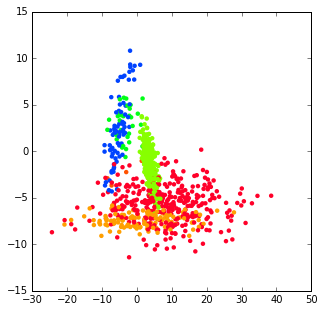

In [58]:
plot_data(x_n, c_n, size=(5,5), seed=1)

# Mixture of Finite Mixtures

In [71]:
# pm = imm.models.MFM(mm, gamma=1., mu=5., seed=4)
pm = imm.models.MFM(mm, gamma=1., mu=10., seed=2)

In [72]:
x_n, c_n = pm.draw(size=1000)

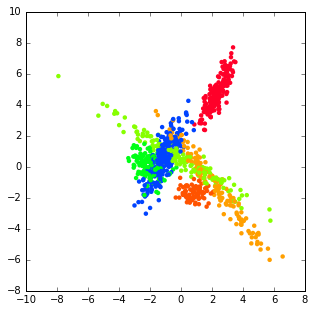

In [73]:
plot_data(x_n, c_n, size=(5,5), seed=1)

# Collapsed Gibbs Sampler

In [74]:
s = imm.samplers.CollapsedGibbsSampler(pm, max_iter=1000, warmup=0)

In [75]:
c_n_gibbs, _ = pm.infer(x_n, sampler=s)

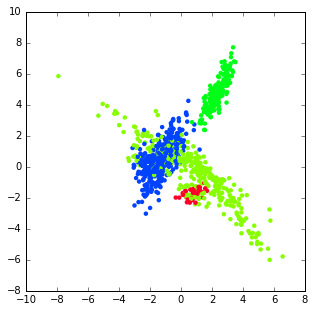

In [76]:
plot_data(x_n, c_n_gibbs[-1], size=(5,5), seed=1)

In [77]:
anim_data(x_n, c_n_gibbs, size=(5,5), seed=1)

# Collapsed Merge-Split Sampler

In [78]:
s = imm.samplers.CollapsedRGMSSampler(pm, scheme=(5,1,1), max_iter=100,
                                      warmup=0)

In [79]:
c_n_rgms, _ = pm.infer(x_n, sampler=s)

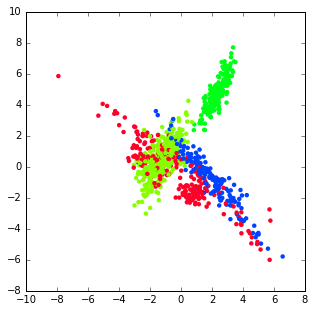

In [80]:
plot_data(x_n, c_n_rgms[-1], size=(5,5), seed=1)

In [81]:
anim_data(x_n, c_n_rgms, size=(5,5), seed=1)

# Collapsed SAMS Sampler

In [82]:
s = imm.samplers.CollapsedSAMSSampler(pm, max_iter=100, warmup=0)

In [83]:
c_n_sams, _ = pm.infer(x_n, sampler=s)

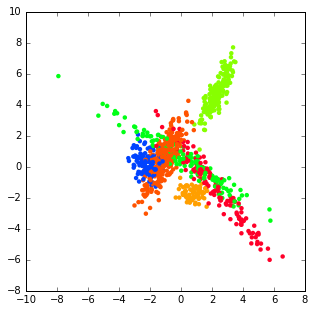

In [84]:
plot_data(x_n, c_n_sams[-1], size=(5,5), seed=1)

In [85]:
anim_data(x_n, c_n_sams, size=(5,5), seed=1)

# Gibbs Sampler

In [59]:
s = imm.samplers.GibbsSampler(pm, max_iter=100, warmup=0)

In [67]:
c_n_gibbs, phi_c_gibbs = pm.infer(x_n, sampler=s)

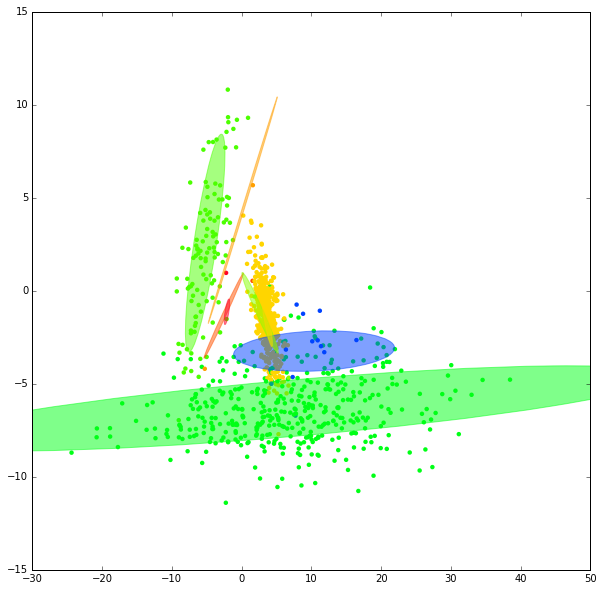

In [68]:
plot_data(x_n, c_n_gibbs[-1], phi_c_gibbs[-1], size=(10,10), seed=1)

In [69]:
anim_data(x_n, c_n_gibbs, phi_c_gibbs, seed=1)

# Merge-Split Sampler

In [63]:
s = imm.samplers.RGMSSampler(pm, scheme=(10,1,1,10), max_iter=100, warmup=0)

In [64]:
c_n_rgms, phi_c_rgms = pm.infer(x_n, sampler=s)

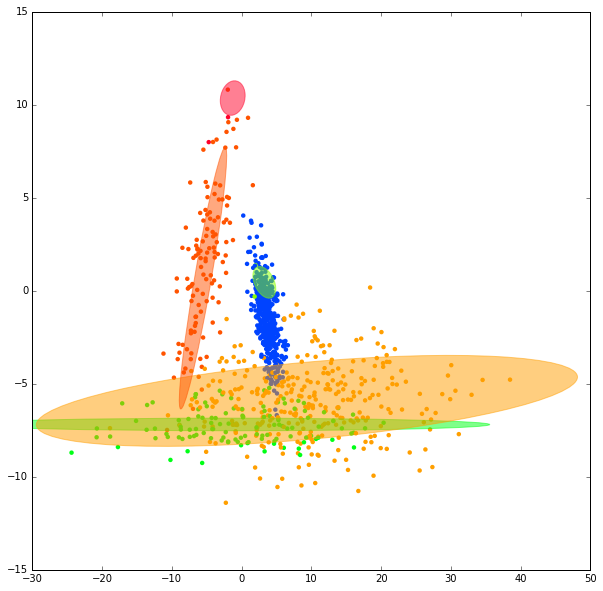

In [65]:
plot_data(x_n, c_n_rgms[-1], phi_c_rgms[-1], size=(10,10), seed=1)

In [66]:
anim_data(x_n, c_n_rgms, phi_c_rgms, seed=1)